# [Media Effect Estimation with Orbit's KTR Model](https://juanitorduz.github.io/orbit_mmm/)

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.ndimage import gaussian_filter
import seaborn as sns
from typing import Union

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
"""
Create a DataFrame with a date range from 'min_date' to 'max_date' with a frequency of weekly starting on Mondays.
Add additional columns for year, month, and day of the year.
"""

min_date = pd.to_datetime("2018-04-01")
max_date = pd.to_datetime("2021-09-01")

data_df = pd.DataFrame(
    data={"date": pd.date_range(start=min_date, end=max_date, freq="W-MON")}
)

data_df = data_df.assign(
    year = lambda x: x["date"].dt.year,
    month = lambda x: x["date"].dt.month,
    dayofyear = lambda x: x["date"].dt.dayofyear,
)

n = data_df.shape[0]

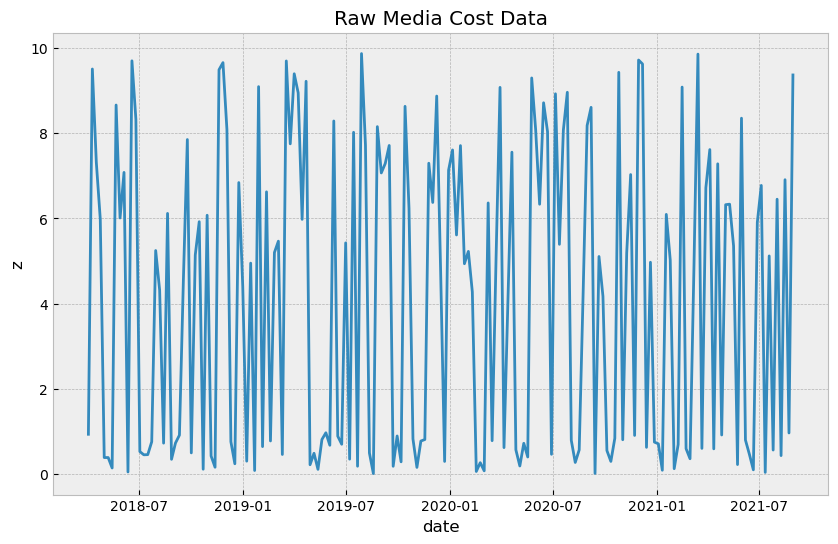

In [7]:
# Set the random seed for reproducibility
SEED = 42
np.random.seed(SEED)

# Sample from a uniform distribution on [0, 1] and cut at the threshold (0.4)
z = np.random.uniform(low=0.0, high=1.0, size=n)
data_df["z"] = 10 * np.where(z > 0.4, z, z/4)

# Create a line plot of the 'z' column against the 'date' column
fig, ax = plt.subplots()
sns.lineplot(x="date", y="z", data=data_df, ax=ax)
ax.set(title="Raw Media Cost Data");

In [9]:
class GeometricAdstockTransformer(BaseEstimator, TransformerMixin):
    """Transforms input data using the geometric adstock model.

    Args:
        alpha (float): The decay factor for the adstock transformation. Default is 0.0.
        l (int): The length of the adstock window. Default is 12.
    """

    def __init__(self, alpha: float = 0.0, l: int = 12):
        self.alpha = alpha
        self.l = l

    def fit(self, x: Union[pd.DataFrame, np.ndarray], y=None) -> "GeometricAdstockTransformer":
        """Fit the transformer to the input data.

        Args:
            x (pd.DataFrame or np.ndarray): The input data to fit the transformer on.
            y: Ignored. Present for compatibility.

        Returns:
            self (GeometricAdstockTransformer): The fitted transformer object.
        """
        return self

    def transform(self, x: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        """Transform the input data using the geometric adstock model.

        Args:
            x (pd.DataFrame or np.ndarray): The input data to transform.

        Returns:
            np.ndarray: The transformed data.
        """
        if isinstance(x, pd.DataFrame):
            x = x.to_numpy()
        cycles = [
            np.append(
                arr=np.zeros(shape=x.shape)[:i],
                values=x[: x.shape[0] - i],
                axis=0
            ) 
            for i in range(self.l)
        ]
        x_cycle = np.stack(cycles, axis=0)
        w = np.array([np.power(self.alpha, i) for i in range(self.l)])
        return np.tensordot(a=w, b=x_cycle, axes=1)

In [10]:
# the effect carryover factor is 1/2 (usual assumption)
alpha = 1/2
# The carryover period is 12 weeks, which is also quite reasonable.
l = 12 

geometric_adstock_transformer = GeometricAdstockTransformer(alpha=alpha, l=l)

data_df["z_adstock"] = geometric_adstock_transformer.fit_transform(data_df["z"])

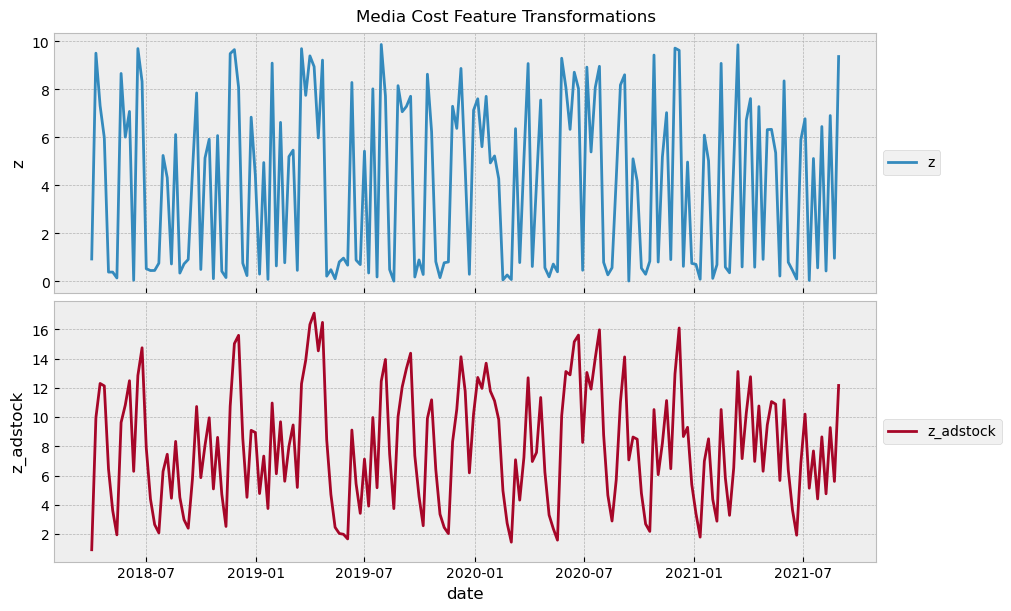

In [11]:
fig, axes = plt.subplots(
  nrows=2,
  ncols=1,
  sharex=True,
  sharey=False,
  layout="constrained"
)

features = ["z", "z_adstock"]

for i, (col, ax) in enumerate(zip(features, axes.flatten())):
    sns.lineplot(x="date", y=col, color=f"C{i}", label=col, data=data_df, ax=ax)
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

fig.suptitle("Media Cost Feature Transformations");

In [12]:
class LogisticSaturationTransformer(BaseEstimator, TransformerMixin):
    """Transforms input data using the logistic saturation model.

    Args:
        mu (float): The saturation factor for the transformation. Default is 0.5.
    """

    def __init__(self, mu: float = 0.5):
        self.mu = mu

    def fit(self, x: Union[pd.DataFrame, np.ndarray], y=None) -> "LogisticSaturationTransformer":
        """Fit the transformer to the input data.

        Args:
            x (pd.DataFrame or np.ndarray): The input data to fit the transformer on.
            y: Ignored. Present for compatibility.

        Returns:
            self (LogisticSaturationTransformer): The fitted transformer object.
        """
        return self

    def transform(self, x: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        """Transform the input data using the logistic saturation model.

        Args:
            x (pd.DataFrame or np.ndarray): The input data to transform.

        Returns:
            np.ndarray: The transformed data.
        """
        if isinstance(x, pd.DataFrame):
            x = x.to_numpy()
        return (1 - np.exp(-self.mu * x)) / (1 + np.exp(-self.mu * x))

In [13]:
mu = 1.5e-1

logistic_saturation_transformer = LogisticSaturationTransformer(mu=mu)

data_df["z_adstock_saturated"] = logistic_saturation_transformer.fit_transform(data_df["z_adstock"])

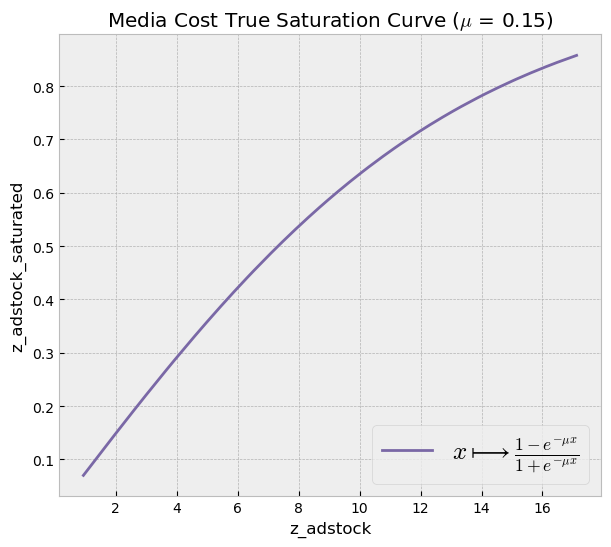

In [14]:
fig, ax = plt.subplots(figsize=(7, 6))

latex_function = r"$x\longmapsto \frac{1 - e^{-\mu x}}{1 + e^{-\mu x}}$"
sns.lineplot(
    x="z_adstock",
    y="z_adstock_saturated",
    color="C2",
    label=latex_function,
    data=data_df,
    ax=ax
)
ax.legend(loc="lower right", prop={"size": 18})
ax.set(title=f"Media Cost True Saturation Curve ($\mu$ = {mu})");

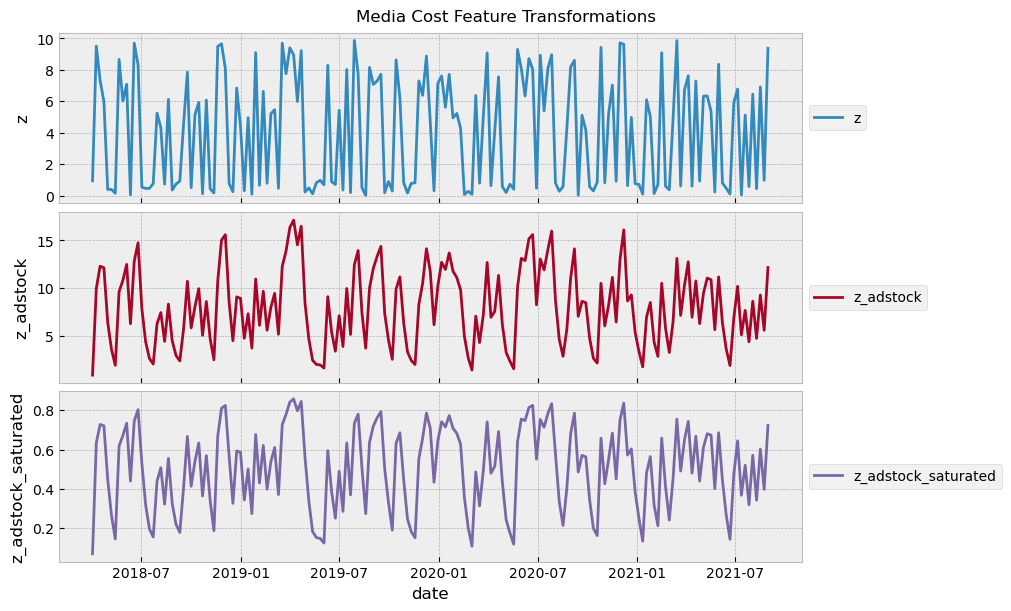

In [15]:
fig, axes = plt.subplots(
  nrows=3,
  ncols=1,
  sharex=True,
  sharey=False,
  layout="constrained"
)

features = ["z", "z_adstock", "z_adstock_saturated"]

for i, (col, ax) in enumerate(zip(features, axes.flatten())):
    sns.lineplot(x="date", y=col, color=f"C{i}", label=col, data=data_df, ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.suptitle("Media Cost Feature Transformations");

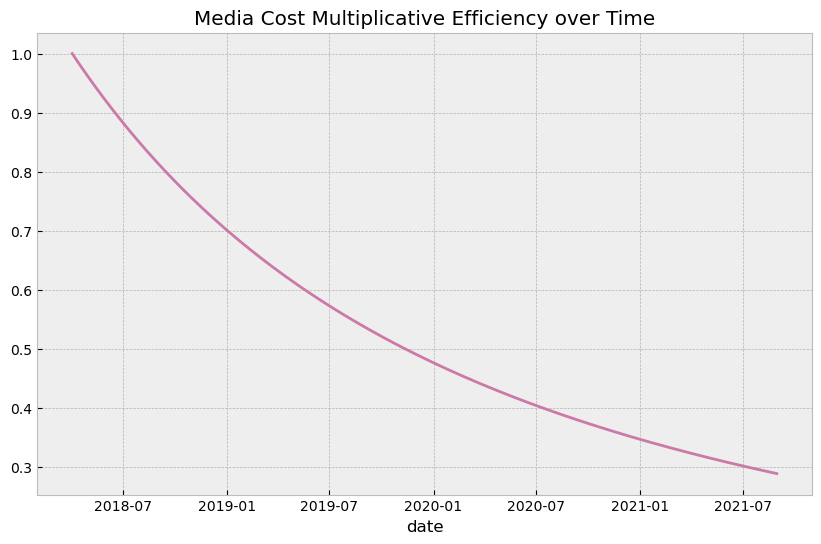

In [16]:
data_df["beta"] =  (np.arange(start=0.0, stop=1.0, step=1/n) + 1) ** (-1.8)

fig, ax = plt.subplots()
sns.lineplot(x="date", y="beta", color="C5", data=data_df, ax=ax)
ax.set(title="Media Cost Multiplicative Efficiency over Time", ylabel=None);

In [17]:
data_df["z_effect"] = data_df["beta"] * data_df["z_adstock_saturated"]

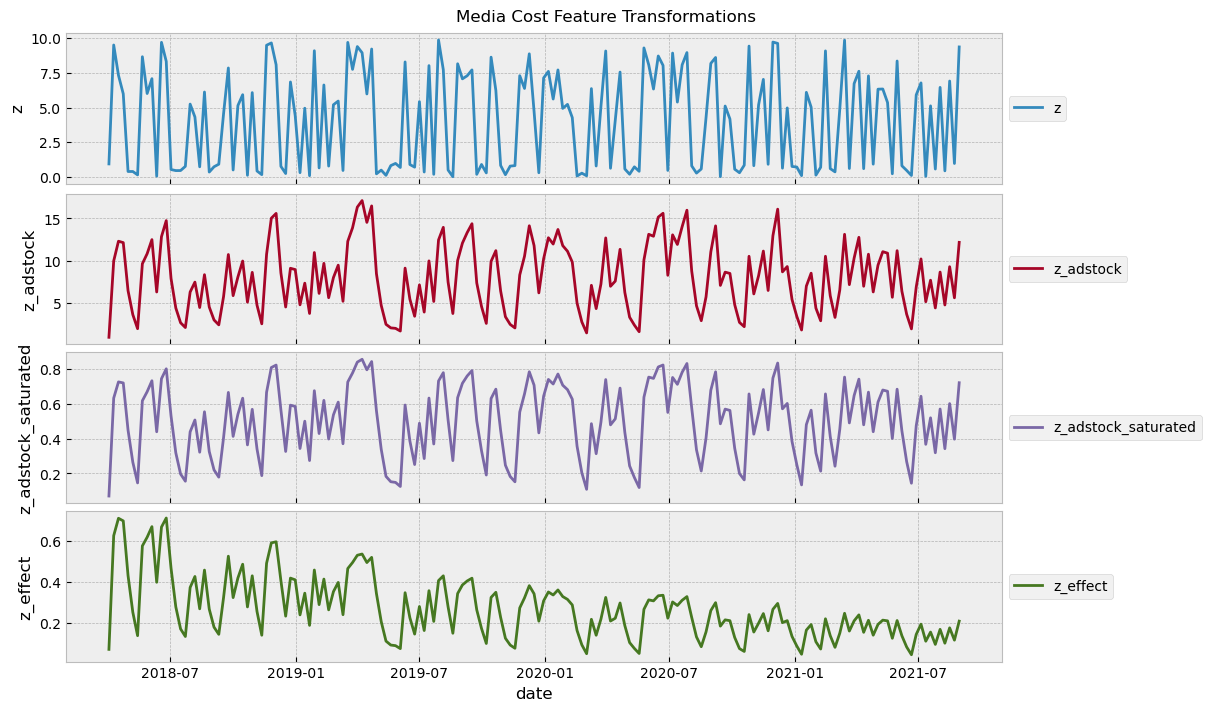

In [18]:
fig, axes = plt.subplots(
    nrows=4,
    ncols=1,
    figsize=(12, 7),
    sharex=True,
    sharey=False,
    layout="constrained"
)

features = ["z", "z_adstock", "z_adstock_saturated", "z_effect"]

for i, (col, ax) in enumerate(zip(features, axes.flatten())):
    sns.lineplot(x="date", y=col, color=f"C{i}", label=col, data=data_df, ax=ax)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.suptitle("Media Cost Feature Transformations");

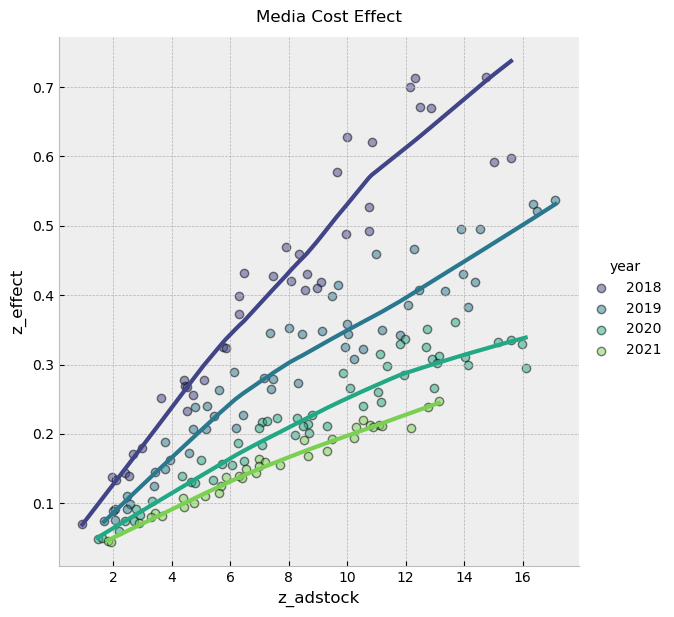

In [19]:
g = sns.lmplot(
    x="z_adstock",
    y="z_effect",
    hue="year",
    palette="viridis",
    lowess=True,
    scatter_kws={"edgecolor": "black", "alpha": 0.5},
    height=6,
    data=data_df
)
g.fig.suptitle("Media Cost Effect", y=1.02);

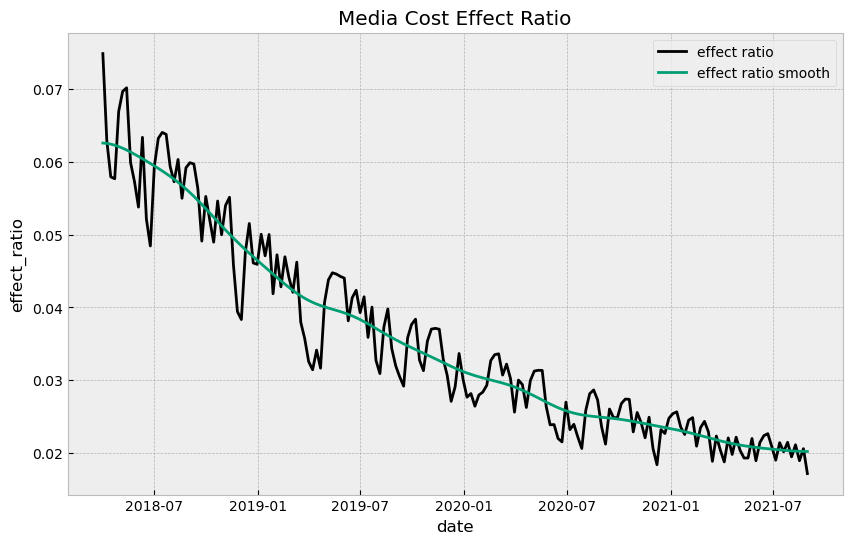

In [22]:
data_df.eval(expr="effect_ratio = z_effect / z_adstock", inplace=True)

data_df["effect_ratio_smooth"] = gaussian_filter(input=data_df["effect_ratio"], sigma=8)

fig, ax = plt.subplots()
sns.lineplot(x="date", y="effect_ratio", color="black", label="effect ratio", data=data_df, ax=ax)
sns.lineplot(x="date", y="effect_ratio_smooth", color="C7", label="effect ratio smooth", data=data_df, ax=ax)
ax.set(title="Media Cost Effect Ratio");

In [23]:
data_df["trend"] = (np.linspace(start=0.0, stop=50, num=n) + 10)**(1/4) - 1 

In [24]:
data_df["cs"] = - np.sin(2 * 2 * np.pi * data_df["dayofyear"] / 365.5) 
data_df["cc"] = np.cos(1 * 2 * np.pi * data_df["dayofyear"] / 365.5)
data_df["seasonality"] = 0.25 * (data_df["cs"] + data_df["cc"])

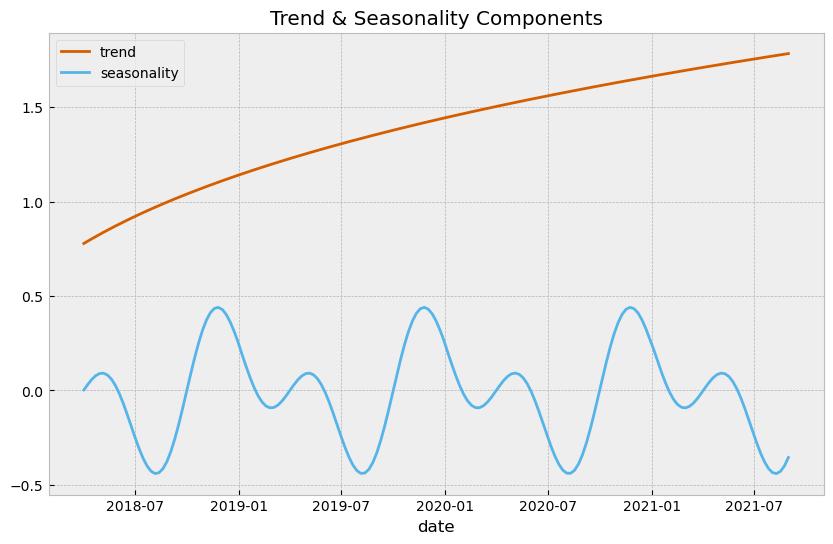

In [25]:
fig, ax = plt.subplots()
sns.lineplot(x="date", y="trend", color="C4", label="trend", data=data_df, ax=ax)
sns.lineplot(x="date", y="seasonality", color="C6", label="seasonality", data=data_df, ax=ax)
ax.legend(loc="upper left")
ax.set(title="Trend & Seasonality Components", ylabel="");

In [26]:
np.random.seed(SEED)

data_df["intercept"] = 3.0
data_df["trend_plus_intercept"] = data_df["trend"] + data_df["intercept"]

# the noise variance is increasing to make sure the resulting time series has constant variance
sigma_epsilon  = np.linspace(start=3e-2, stop=7e-2, num=n)
data_df["epsilon"] = np.random.normal(loc=0.0, scale=sigma_epsilon)

In [27]:
data_df.eval(expr="y = intercept + trend + seasonality + z_effect + epsilon", inplace=True)

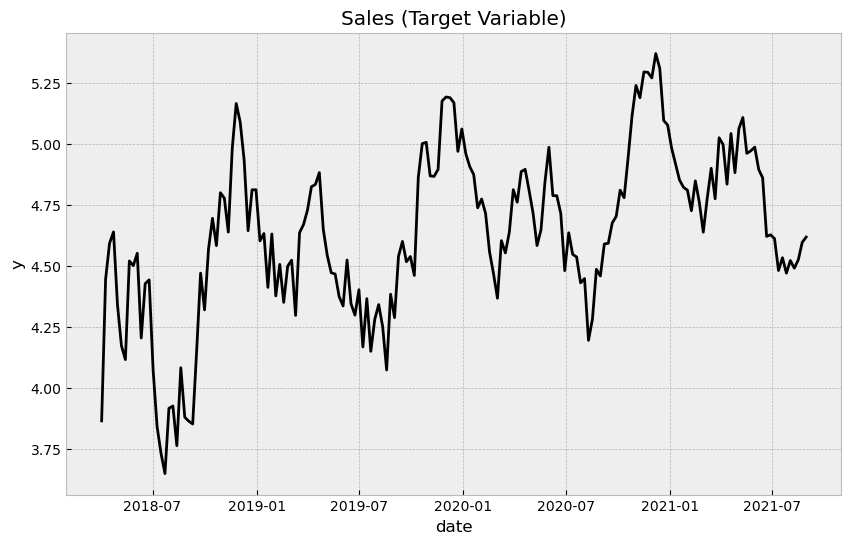

In [28]:
fig, ax = plt.subplots()
sns.lineplot(x="date", y="y", color="black", data=data_df, ax=ax)
ax.set(title="Sales (Target Variable)");

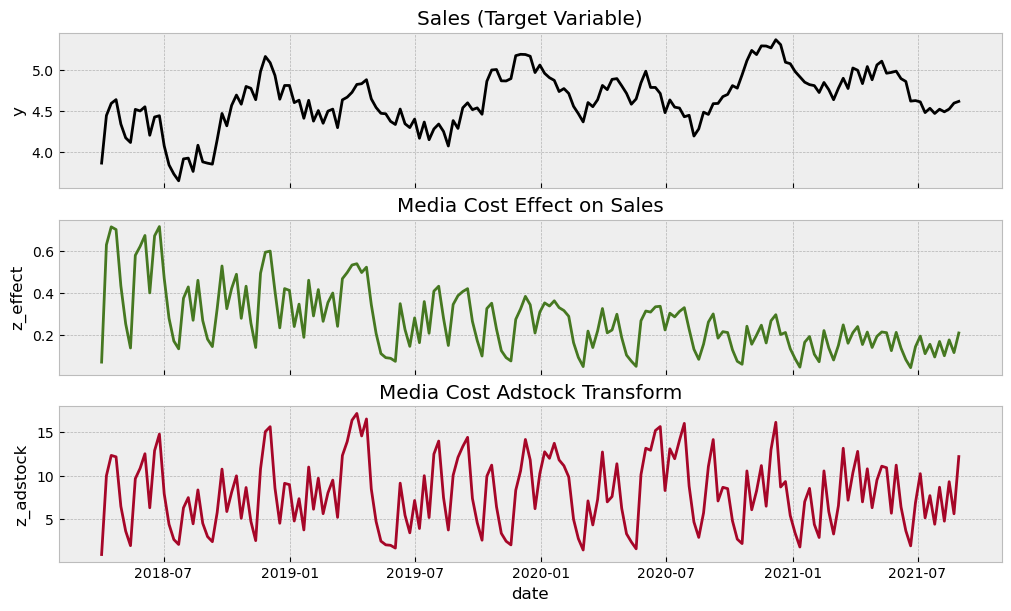

In [29]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=False, layout="constrained")
sns.lineplot(x="date", y="y", color="black", data=data_df, ax=axes[0])
axes[0].set(title="Sales (Target Variable)")
sns.lineplot(x="date", y="z_effect", color="C3", data=data_df, ax=axes[1])
axes[1].set(title="Media Cost Effect on Sales")
sns.lineplot(x="date", y="z_adstock", color="C1", data=data_df, ax=axes[2])
axes[2].set(title="Media Cost Adstock Transform");

In [30]:
data_df

,date,year,month,dayofyear,z,z_adstock,z_adstock_saturated,beta,z_effect,effect_ratio,effect_ratio_smooth,trend,cs,cc,seasonality,intercept,trend_plus_intercept,epsilon,y
0,2018-04-02,2018,4,92,0.936350,0.936350,0.070111,1.000000,0.070111,0.074877,0.062576,0.778279,0.021487,-0.010744,0.002686,3.0,3.778279,0.014901,3.865978
1,2018-04-09,2018,4,99,9.507143,9.975318,0.634043,0.990022,0.627717,0.062927,0.062525,0.790638,0.259165,-0.130704,0.032115,3.0,3.790638,-0.004179,4.446291
2,2018-04-16,2018,4,106,7.319939,12.307599,0.727346,0.980198,0.712944,0.057927,0.062426,0.802746,0.481904,-0.248773,0.058283,3.0,3.802746,0.019722,4.593694
3,2018-04-23,2018,4,113,5.986585,12.140384,0.721386,0.970526,0.700123,0.057669,0.062280,0.814614,0.676865,-0.363245,0.078405,3.0,3.814614,0.046718,4.639861
4,2018-04-30,2018,4,120,0.390047,6.460239,0.449855,0.961000,0.432310,0.066919,0.062093,0.826254,0.832810,-0.472462,0.090087,3.0,3.826254,-0.007235,4.341417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,2021-08-02,2021,8,214,6.451728,8.655915,0.571127,0.294538,0.168218,0.019434,0.020254,1.770035,-0.879312,-0.859141,-0.434613,3.0,4.770035,0.019120,4.522760
175,2021-08-09,2021,8,221,0.435916,4.762566,0.342739,0.293042,0.100437,0.021089,0.020220,1.773333,-0.967484,-0.791496,-0.439745,3.0,4.773333,0.057345,4.491370
176,2021-08-16,2021,8,228,6.909377,9.290605,0.602330,0.291558,0.175614,0.018902,0.020194,1.776620,-0.999887,-0.712405,-0.428073,3.0,4.776620,0.000904,4.525065
177,2021-08-23,2021,8,235,0.966838,5.610102,0.397568,0.290085,0.115329,0.020557,0.020176,1.779895,-0.974654,-0.623010,-0.399416,3.0,4.779895,0.101421,4.597228


In [35]:
data_df.to_csv('../../../data/mock/mock_data_orduz.csv', index=True, index_label="index")